# Exercise 10: Diffusion problems

Up to now, we were concerned with steady-state problems and solutions to the Laplace and Poisson equation. However, in subsurface reservoir problems, we are a lot more often concerned with the evaluation of properties that change with time! 

From now on, we will investigate several of these transient problems and investigate how (a) they relate to the problems we considered previously, and (b) present some new numerical challenges.

Today, we will look at problems that can be described with a diffusion-type equation: 

$$\frac{\partial u}{\partial t} = \kappa \frac{\partial^2 u}{\partial x^2}$$

We will talk in the lecture about how diffusive systems generally behave over time. Typical examples of diffusive problems in the context of reservoir engineering are, for example, conductive heat transport:

$$\frac{\partial T}{\partial t} = \kappa \frac{\partial^2 T}{\partial x^2}$$

where $\kappa$ is thermal diffusivity, or groundwater flow in a confined aquifer:

$$\frac{\partial h}{\partial t} = \frac{T}{S} \frac{\partial^2 h}{\partial x^2}$$

where $T$ is transmissivity, and $S$ the (depth-averaged) storativity.

If we want to solve these equations numerically, we now have to find discretisations in time and space. We will look at several options to do that in this notebook.

In [1]:
#from IPython.core.display import HTML
#css_file = 'nre2_style.css'
#HTML(open(css_file, "r").read())


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
plt.rcParams['figure.figsize'] = [10., 7.]
plt.rcParams['font.size'] = 16

In [3]:
%matplotlib inline

## Explicit scheme to solve the diffusion equation

We discussed in the lecture different schemes to solve the diffusion equation 

$$\frac{\partial u}{\partial t} = \kappa \frac{\partial^2 u}{\partial x^2}$$

with the finite difference method. The simplest - and most intuitive - way is to use a first-order Taylor expansion for the time derivative:

$$\frac{u_i^{k+1} - u_i^k}{\Delta t} = \kappa \frac{u_{i-1}^k - 2 u_i^k + u_{i+1}^k}{\Delta x^2} $$

If we now separate the variables for a new time step $k+1$ and the current time step $k$, we obtain the simple explicit formulation for the 1-D diffusion equation:

$$u_i^{k+1} = \frac{\kappa \Delta t}{\Delta x^2} \left( u_{i-1}^k - 2 u_i^k + u_{i+1}^k \right) + u_i^k$$

For simplification, we substitute $\frac{\kappa \Delta t}{\Delta x^2} = \beta$ and obtain:

$$u_i^{k+1} = \beta u_{i-1}^k + (1 - 2 \beta) u_i^k + \beta u_{i+1}^k $$

As this equation provides a function for an update of one node value from all the known node values at the previous time step, we can define a simple python function to solve the diffusion problem.

We now need an initial distribution of our property $u$ in the domain. Let's use a simple function for an initial distribution of our property:

$$u(x, t=0) = u_{max} \exp \left[ - \left( \frac{x-0.5}{\sigma} \right)^2 \right]$$

Let's have a look at a diffusion problem in a domain with the following properties:

Variable | Value  | Explanation
------------- | -------------
$L$  | 1. | Domain size
$\kappa$ | $10^{-6}$ | Diffusivity
$dt$ | 25. | Time step
$nt$ | 200 | Number of time steps
$nx$ | 100 | Number of cells
$u_{max}$ | 10. | Maximum value of initial perturbance
$\sigma$ | 0.05 | Half-width of initial perturbance

Write a code to solve this problem and create a plot with the initial and final distribution of the property:

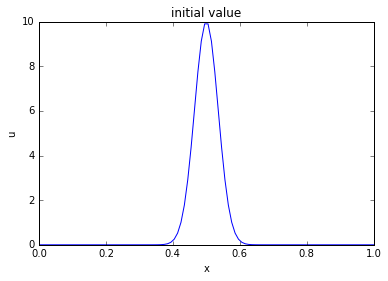

In [4]:
# your code here:
xvals = np.linspace(0,1,100)
plt.plot(xvals, 10. * np.exp(-((xvals - 0.5)/0.05)**2))
plt.xlabel('x')
plt.ylabel('u')
plt.title("initial value")

## Explicit equation in matrix form

The explicit solution of the equation is easily possible with a simple loop scheme that we have seen above. However, in order to show you the similarities to the types of problems we solved before, we will now have a look at another representation of the equation. This will also lay the groundwork for the subsequent, more complex, schemes.

We start with the equation that we solved before:

$$u_i^{k+1} = \beta u_{i-1}^k + (1 - 2 \beta) u_i^k + \beta u_{i+1}^k $$

If you look at the equation on the right hand side and think about the solutions to the Laplace and Poisson problems that we analysed before, you will see a similarity: we can write it in matrix form and obtain a tridiagonal matrix, again!

We define: 

$$A = \begin{bmatrix}
1 - 2\beta & \beta & 0 & 0 & \cdots & 0\\
\beta & 1 - 2\beta  &  \beta &  0 & \cdots & 0\\
0 &  \beta & 1 - 2\beta  &  \beta & \cdots & 0\\
\vdots & & &  \ddots & & \vdots \\
0 & \cdots & 0 &  \beta & 1 - 2\beta  &  \beta \\
0 & \cdots & 0 & 0 &  \beta & 1 - 2\beta 
\end{bmatrix}$$

And writing the variables $u$ in a column vector,

$$u^k = \begin{bmatrix}
u_1^k\\
u_2^k\\
u_3^k\\
\vdots\\
u_{i-1}^k\\
u_i^k
\end{bmatrix}$$

We can write the equation in matrix form:

$$u^{k+1} = A u^k$$

## Boundary conditions

One thing that we neglected so far are boundary conditions. We will first have a look at Dirichlet boundary conditions. If you write down the equation for the first node, you can see that the implementation of boundary conditions will be very similar to the Laplace equations before:

$$u_1^{k+1} = \beta\,u_{0}^k + (1 - 2 \beta)\,u_1^k + \beta\,u_{2}^k $$

We now simply assign the boundary value $b_0$ for $u_0^k$ and, accordingly, for the last value $u_n$ and obtain a column vector for the boundary conditions as:


$b = \begin{bmatrix}
b_0\\
0\\
0\\
\vdots\\
0\\
b_1
\end{bmatrix}$

If we now add this vector to the previous matrix equation, we obtain the explicit equation for the diffusion equation with dirichlet boundary conditions as:

$u^{k+1} = A u^k + \beta b$

**Your task**: write the code to solve the problem described above with a matrix method (with Dirichlet BC's $b_0 = 0$ and $b_1 = 0$).


0.525


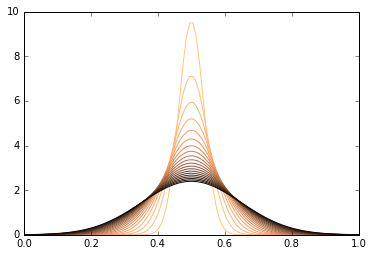

In [5]:
# your code
L = 1.
kappa = 2.1e-6
dt = 25
nt = 200
nx= 100
umax = 10
sigma = 0.05
dx = L/nx

beta = (kappa*dt) / (dx**2)

##########################################

def tridiag(nx,beta):
    A = np.zeros(shape=(nx,nx))
    i,j = np.indices(A.shape)
    A[i==j] = 1-2*beta
    A[i==j-1] = beta
    A[i==j+1] = beta
    return  A


#########################################

u = np.ones((nx,nx))


xvals = np.linspace(0,1,100)
u =  umax * np.exp(-((xvals - 0.5)/0.05)**2)

b = np.zeros(nx)
b0=0
b1=0
b[0] = b0
b[-1] = b1

A = tridiag(nx,beta)

for i in range(nt):
    u = np.dot(A,u) + np.dot(beta,b)
    #plt.plot(u)
    if np.mod(i,10) == 0: plt.plot(xvals,u,color=plt.cm.copper_r(i/200.))

print beta

## Stability estimation

Unfortunately, the previously described explicit scheme is not unconditionally stable. 

**Your task**: try out with your code above what happens when you change parameters such that $2 \kappa t > x^2$:

0.55


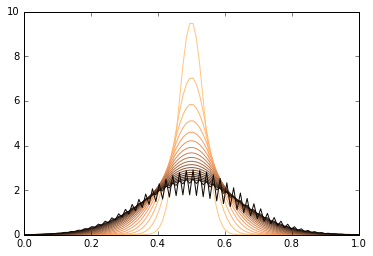

In [8]:
# your code
L = 1.
kappa = 2.2e-6
dt = 25
nt = 200
nx= 100
umax = 10
sigma = 0.05
dx = L/nx

beta = (kappa*dt) / (dx**2)

##########################################

def tridiag(nx,beta):
    A = np.zeros(shape=(nx,nx))
    i,j = np.indices(A.shape)
    A[i==j] = 1-2*beta
    A[i==j-1] = beta
    A[i==j+1] = beta
    return  A


#########################################

u = np.ones((nx,nx))


xvals = np.linspace(0,1,100)
u =  umax * np.exp(-((xvals - 0.5)/0.05)**2)

b = np.zeros(nx)
b0=0
b1=0
b[0] = b0
b[-1] = b1

A = tridiag(nx,beta)

for i in range(nt):
    u = np.dot(A,u) + np.dot(beta,b)
    #plt.plot(u)
    if np.mod(i,10) == 0: plt.plot(xvals,u,color=plt.cm.copper_r(i/200.))

print beta


What happens? And why? $Unstability occurs$

Preview to lecture: The stability for the explicit scheme based on the Neumann stability analysis. The stability criterion for our scheme (CD in space, FD in time) is:

$\beta = \frac{\kappa \Delta t}{\Delta x^2} < 0.5$

## Implicit scheme to solve the diffusion problem

We will talk in the lecture about other possibilities to determine the spatial gradients. If we take the gradients at time step $k$, then we obtain the explicit scheme from above. Let's now have  a look at the case when we consider $k+1$. Applying the same Finite Difference schemes, but now for $k+1$ in the spatial gradients, we obtain:


$$\frac{u_i^{k+1} - u_i^k}{\Delta t} = \kappa \frac{u_{i-1}^{k+1} - 2 u_i^{k+1} + u_{i+1}^{k+1}}{\Delta x^2} $$

If we now separate the variables for a new time step $k+1$ and the current time step $k$, we obtain:

$$u_i^{k+1} - \frac{\kappa \Delta t}{\Delta x^2} \left( u_{i-1}^{k+1} - 2 u_i^{k+1} + u_{i+1}^{k+1} \right) = u_i^k$$

For simplification, we substitute $\frac{\kappa \Delta t}{\Delta x^2} = \beta$ and obtain:

$$- \beta u_{i-1}^{k+1} + (1 + 2 \beta) u_i^{k+1} - \beta u_{i+1}^{k+1} = u_i^k $$

So, we now obtain an equation with several more unknowns on the left hand side! However, this equation should, again, look very similar to the solutions of the Laplace equation when we write it in matrix form! We separate the left hand side into a matrix $B$ and a column vector $u^{k+1}$:

$$B = \begin{bmatrix}
1 + 2\beta & -\beta & 0 & 0 & \cdots & 0\\
-\beta & 1 + 2\beta  &  -\beta &  0 & \cdots & 0\\
0 &  -\beta & 1 + 2\beta  &  -\beta & \cdots & 0\\
\vdots & & & & & \vdots \\
0 & \cdots & 0 &  -\beta & 1 + 2\beta  & - \beta \\
0 & \cdots & 0 & 0 &  - \beta & 1 + 2\beta 
\end{bmatrix}$$

The scheme, written in matrix form and, again, considering Dirichlet boundary conditions, is now:

$$B u^{k+1} = u^k + \beta b$$


The implementation is now a bit more complicated as for the simple explicit formulation because we need to solve the entire system of algebraic equations to consider all dependencies (this is why it is an *implicit* method). 

However, we now obtain an equation that is in fact very similar to the Laplace problem and it is directly clear that we can solve the equation with the methods that we discussed previously for solving the Laplace equation!

**Your task**: Solve the problem from above with the implicit method!

Hint:

1. write the equation in a form that you can solve
2. use your favourite method to solve it


2.25


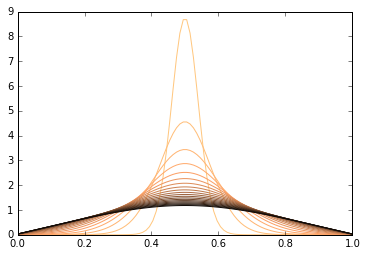

In [21]:
# your code:
# your code
L = 1.
kappa = 9e-6
dt = 25
nt = 200
nx= 100
umax = 10
sigma = 0.05
dx = L/nx

beta = (kappa*dt) / (dx**2)

##########################################

def tridiag(nx,beta):
    B = np.zeros(shape=(nx,nx))
    i,j = np.indices(B.shape)
    B[i==j] = 1+2*beta
    B[i==j-1] = -beta
    B[i==j+1] = -beta
    return  B


#########################################

u = np.ones((nx,nx))


xvals = np.linspace(0,1,100)
u =  umax * np.exp(-((xvals - 0.5)/0.05)**2)

b = np.zeros(nx)
b0=0
b1=0
b[0] = b0
b[-1] = b1

B = tridiag(nx,beta)

for i in range(nt):
    u = np.dot(np.linalg.inv(B),u) + np.dot(np.linalg.inv(B),np.dot(beta,b))
    #plt.plot(u)
    if np.mod(i,10) == 0: plt.plot(xvals,u,color=plt.cm.copper_r(i/200.))

print beta

In [18]:

u = np.dot(np.linalg.inv(B),u) + np.dot(np.linalg.inv(B),np.dot(beta,b))

## Additional questions and tasks

1. Which solution is faster, explicit or implicit? Can you think of ways to speed-up the solution?
2. We discussed the fact that the implicit solution is unconditionally stable! Convince yourself that this is the case!
3. Implement the Crank-Nicolson method